<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n3/GAN_1_Really_Simple_GAN_MNIST_etiquetas_y_balanceo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simplificación de 

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87


In [ ]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY



In [ ]:
# Datos
(X_train, Y_train), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

Y_train = (Y_train-4.5)/4.5

In [ ]:
Y_train.max()

1.0

In [ ]:
Datos = np.zeros((X_train.shape[0],X_train.shape[1]*X_train.shape[2]+1))


In [ ]:
Datos[:,0:X_train.shape[1]*X_train.shape[2]] = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
Datos[:,-1] = Y_train

In [ ]:
Datos.shape

(60000, 785)

In [ ]:

in_shape = Datos.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

In [ ]:
in_shape

(785,)

In [ ]:
# Generador

model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,)))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh'))
model_gen.add(Reshape(in_shape))
model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)             

In [ ]:
# Discriminador

model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape=in_shape))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 785)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               100608    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 108,929
Trainable params: 108,929
Non-trainable params: 0
________________________________________________

In [ ]:
# modelo combinado

model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 785)               1494545   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 108929    
Total params: 1,603,474
Trainable params: 1,599,890
Non-trainable params: 3,584
_________________________________________________________________


In [ ]:

epochs = 5000
batch = 10

# Entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

ratio = 1

for cnt in range(epochs):

    ## train discriminator
    batch_discr = np.round(ratio*batch)
    random_index = np.random.randint(0, len(Datos) - np.int64(batch_discr))
    legit_images = Datos[random_index : random_index + np.int64(batch_discr)].reshape((np.int64(batch_discr),)+in_shape)

    gen_noise = np.random.normal(0, 1, (np.int64(batch_discr), 100))
    syntetic_images = model_gen.predict(gen_noise)

    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch_discr), 1)), np.zeros((np.int64(batch_discr), 1))))

    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    # train generator
    batch_gen = np.int64(np.round(batch/ratio))

    noise = np.random.normal(0, 1, (2*batch_gen, 100))
    y_mislabled = np.ones((2*batch_gen, 1))

    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f], [ batch dicr :: loss: %f], [ batch gen :: loss: %f]' % (cnt, d_loss[0], g_loss, batch_discr, batch_gen))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    
    ratio = DD_loss[cnt]/GG_loss[cnt]
    

Streaming output truncated to the last 5000 lines.
epoch: 2, [Discriminator :: d_loss: 0.515211], [ Generator :: loss: 0.782191], [ batch dicr :: loss: 9.000000], [ batch gen :: loss: 11.000000]
epoch: 3, [Discriminator :: d_loss: 0.455569], [ Generator :: loss: 0.713145], [ batch dicr :: loss: 7.000000], [ batch gen :: loss: 15.000000]
epoch: 4, [Discriminator :: d_loss: 0.424395], [ Generator :: loss: 0.678240], [ batch dicr :: loss: 6.000000], [ batch gen :: loss: 16.000000]
epoch: 5, [Discriminator :: d_loss: 0.396742], [ Generator :: loss: 0.627799], [ batch dicr :: loss: 6.000000], [ batch gen :: loss: 16.000000]
epoch: 6, [Discriminator :: d_loss: 0.482484], [ Generator :: loss: 0.524472], [ batch dicr :: loss: 6.000000], [ batch gen :: loss: 16.000000]
epoch: 7, [Discriminator :: d_loss: 0.468550], [ Generator :: loss: 0.553222], [ batch dicr :: loss: 9.000000], [ batch gen :: loss: 11.000000]
epoch: 8, [Discriminator :: d_loss: 0.481723], [ Generator :: loss: 0.446048], [ batc

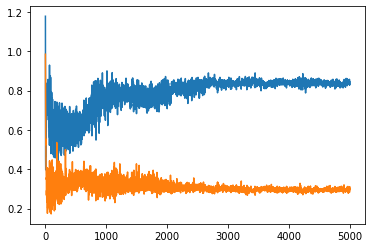

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

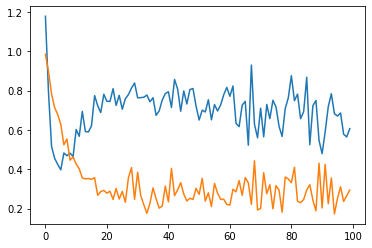

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss[0:100])
plt.plot(GG_loss[0:100])

# Generar datos

In [ ]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
aux_synth = model_gen.predict(gen_noise)

syntetic_images = aux_synth[:,0:-1].reshape((10,28,28,1))
syntetic_labels = aux_synth[:,-1]

syntetic_labels = np.round(syntetic_labels*4.5+4.5)

In [ ]:
syntetic_images.shape

(10, 28, 28, 1)

In [ ]:
syntetic_labels.shape

(10,)

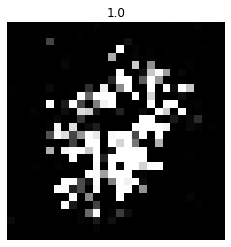

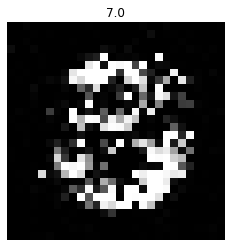

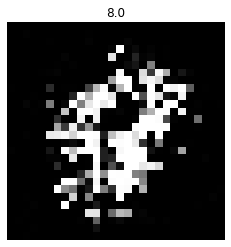

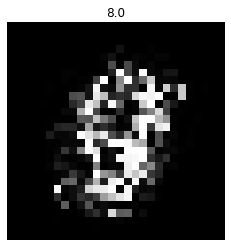

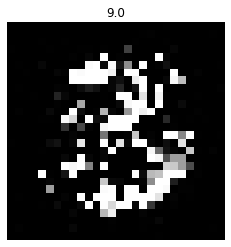

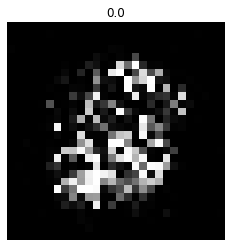

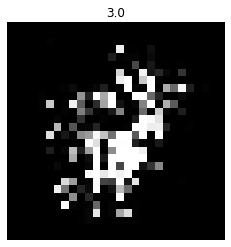

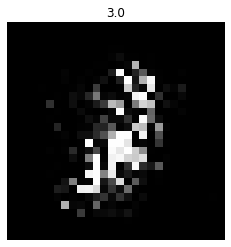

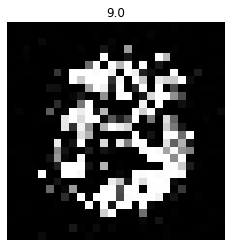

In [ ]:
#imagen = 2

for imagen in range(0,9):
    plt.figure()
    plt.imshow(syntetic_images[imagen,:,:,0],cmap='gray')
    plt.title(syntetic_labels[imagen])
    plt.axis('off')
    #print(syntetic_labels[imagen])

(-0.5, 27.5, 27.5, -0.5)

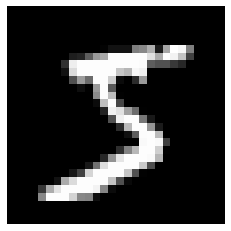

In [ ]:
plt.imshow(X_train[0,:,:,0],cmap='gray')
plt.axis('off')